# Yelp Reviews: Stars on Reviews Unbalanced - Catboost GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
my_dpi = 96

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Apr 13 23:11:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Process format of reviews for word2vec
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

## Word2vec - Reviews: 50 epochs

In [ ]:
# Define parameters for Word2Vec model
model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
model.build_vocab(features)
end = time.time()
print(round(end-start, 2), 'seconds')

Time to build vocab: 74.41 seconds


In [ ]:
# Count number of words in dictionary
vocab_len = len(model.wv.vocab)
print('Number words in the dictionary:', vocab_len)

Number words in the dictionary: 373847


In [ ]:
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
model.train(features, total_examples=model.corpus_count, epochs=50, 
            report_delay=1)
end = time.time()
print(round(end-start,2), 'seconds')

Time to train model: 2857.1 seconds


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Save the model
wv = model.wv
model.wv.save_word2vec_format('gensim_w2vModel_review125_50epochs.bin', 
                              binary=True)

In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for text. 
    The transform function generates mean vectors in model pipelines.
    The class has both fit & transform functions for use in a sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        # If using GloVe, the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        # Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Implement a fit method required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Generates a w2v vector for a set of tokens by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f8fd9071d90>)])

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value)

    # Vectorize
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])
    run_time = timer() - start

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    
    return np.mean(cv_scores)  

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0)
    }

    # Define model
    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Catboost_Optuna_100_GPU.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
176:	learn: 0.1661514	test: 0.1703562	best: 0.1703562 (176)	total: 5.44s	remaining: 9.63s
177:	learn: 0.1660240	test: 0.1702627	best: 0.1702627 (177)	total: 5.47s	remaining: 9.6s
178:	learn: 0.1659191	test: 0.1701820	best: 0.1701820 (178)	total: 5.5s	remaining: 9.56s
179:	learn: 0.1658149	test: 0.1700959	best: 0.1700959 (179)	total: 5.54s	remaining: 9.54s
180:	learn: 0.1657187	test: 0.1700173	best: 0.1700173 (180)	total: 5.57s	remaining: 9.51s
181:	learn: 0.1656461	test: 0.1699438	best: 0.1699438 (181)	total: 5.6s	remaining: 9.48s
182:	learn: 0.1655272	test: 0.1698510	best: 0.1698510 (182)	total: 5.63s	remaining: 9.44s
183:	learn: 0.1654188	test: 0.1697623	best: 0.1697623 (183)	total: 5.66s	remaining: 9.41s
184:	learn: 0.1653280	test: 0.1697003	best: 0.1697003 (184)	total: 5.69s	remaining: 9.38s
185:	learn: 0.1652447	test: 0.1696296	best: 0.1696296 (185)	total: 5.72s	remaining: 9.36s
186:	learn: 0.1651694	test: 0.1695685	best: 0.169568

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_depth': 'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg': 'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf': 'min_data_in_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_one_hot_max_size': 'one_hot_max_size'}, 
                 inplace=True)
trials_df.rename(columns={'params_scale_pos_weight': 'scale_pos_weight'}, 
                 inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
91         91  0.157276 2022-04-13 17:10:28.969106 2022-04-13 17:14:42.014279   
82         82  0.157417 2022-04-13 16:32:49.396929 2022-04-13 16:36:53.488993   
84         84  0.157430 2022-04-13 16:40:59.144103 2022-04-13 16:45:02.537747   
87         87  0.157457 2022-04-13 16:53:30.713335 2022-04-13 16:57:44.874250   
81         81  0.157570 2022-04-13 16:28:50.337370 2022-04-13 16:32:49.396760   
..        ...       ...                        ...                        ...   
26         26  0.689666 2022-04-13 12:47:39.662381 2022-04-13 12:51:40.614719   
2           2  0.690606 2022-04-13 11:12:57.606403 2022-04-13 11:16:54.869753   
1           1  0.691436 2022-04-13 11:08:53.402223 2022-04-13 11:12:57.606247   
3           3  0.691576 2022-04-13 11:16:54.869884 2022-04-13 11:20:51.827427   
30         30  0.693012 2022-04-13 13:03:38.709813 2022-04-13 13:07:33.838411   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU.html')
fig.show()

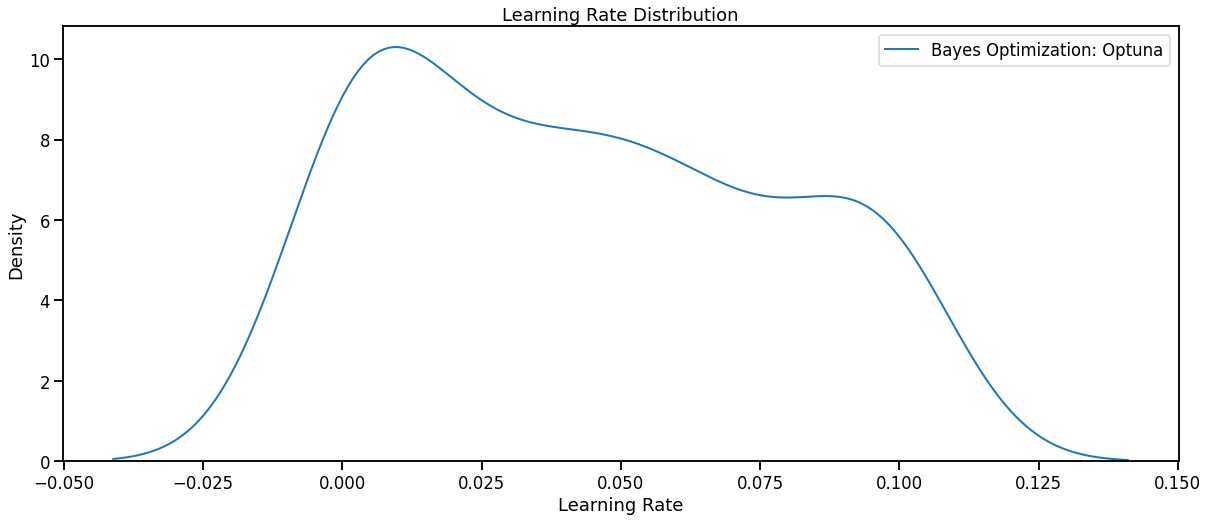

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

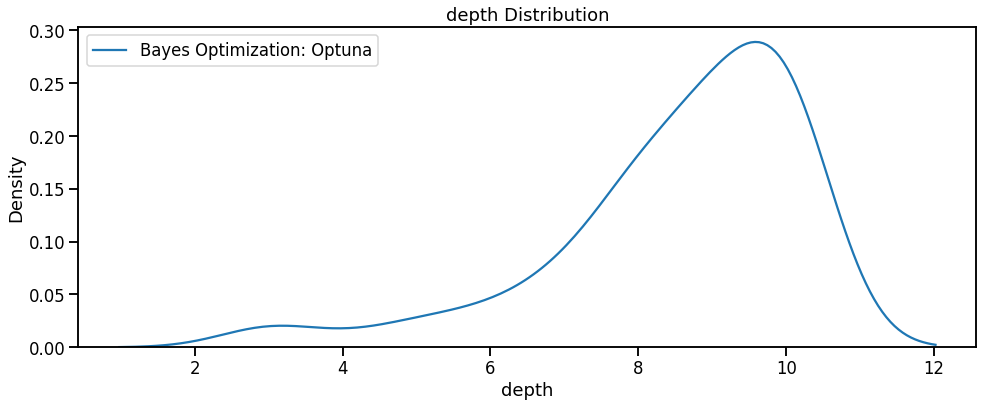

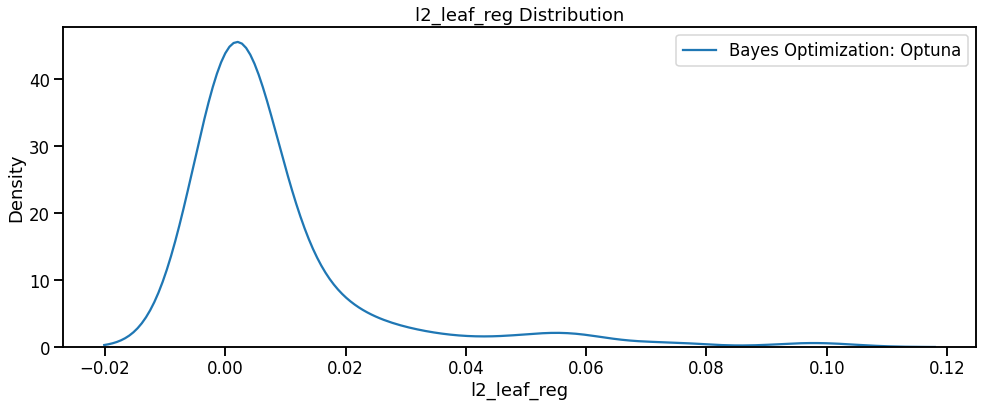

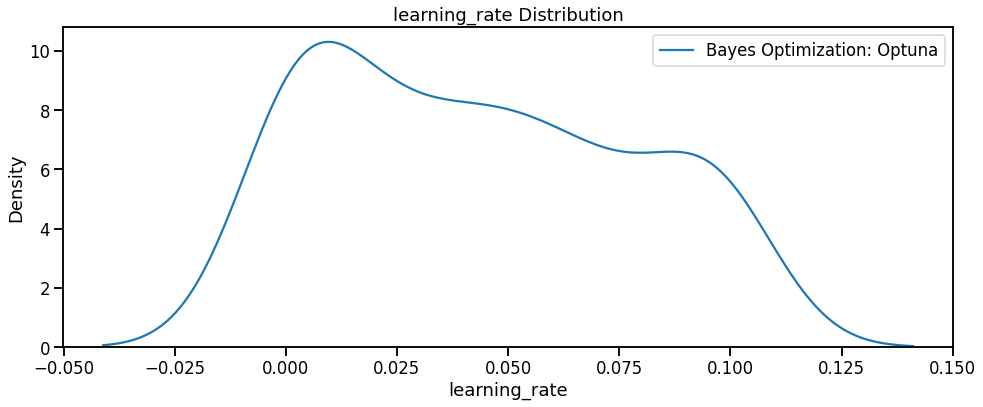

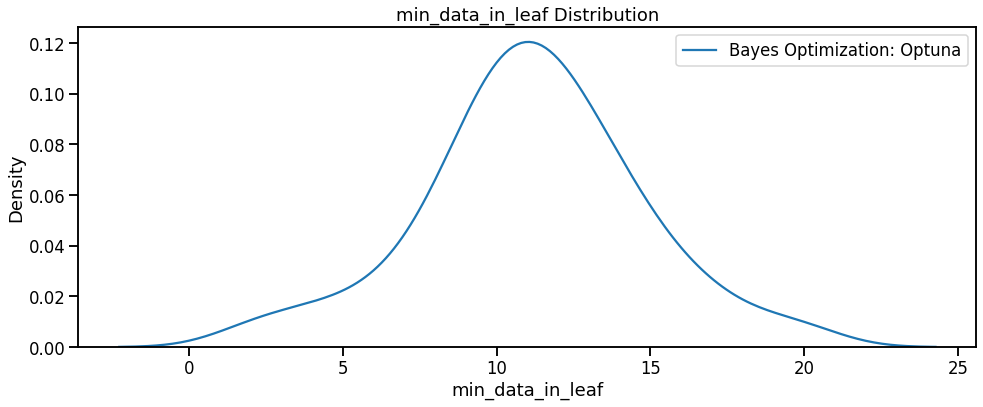

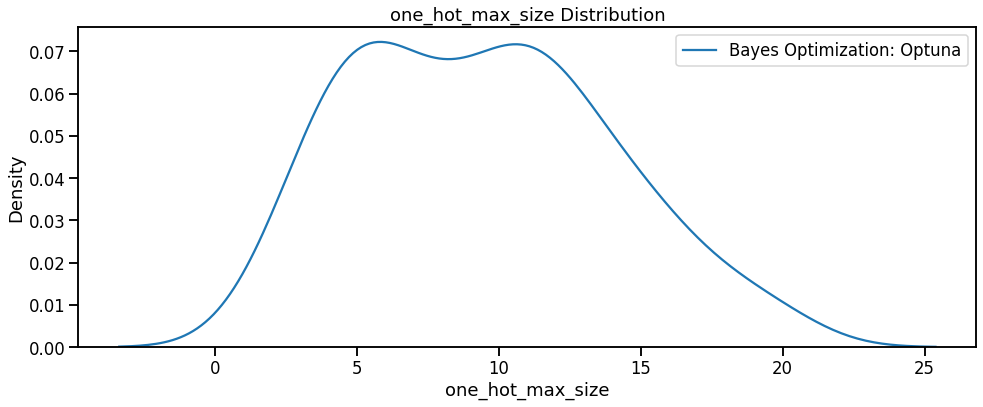

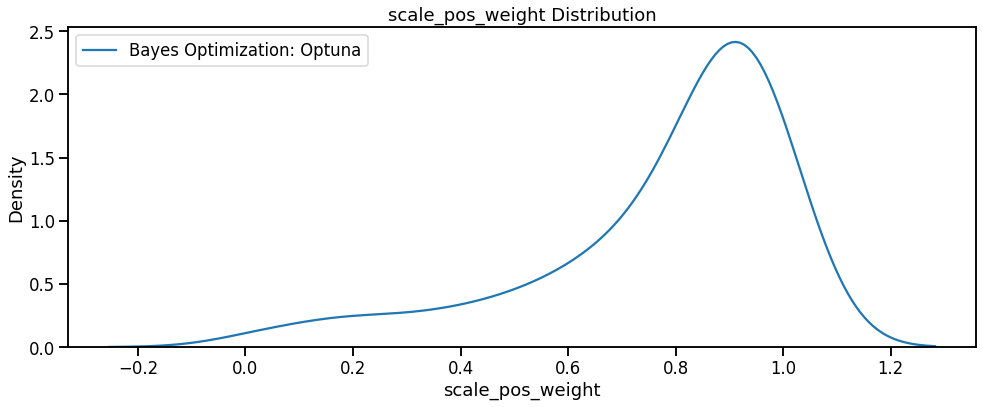

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

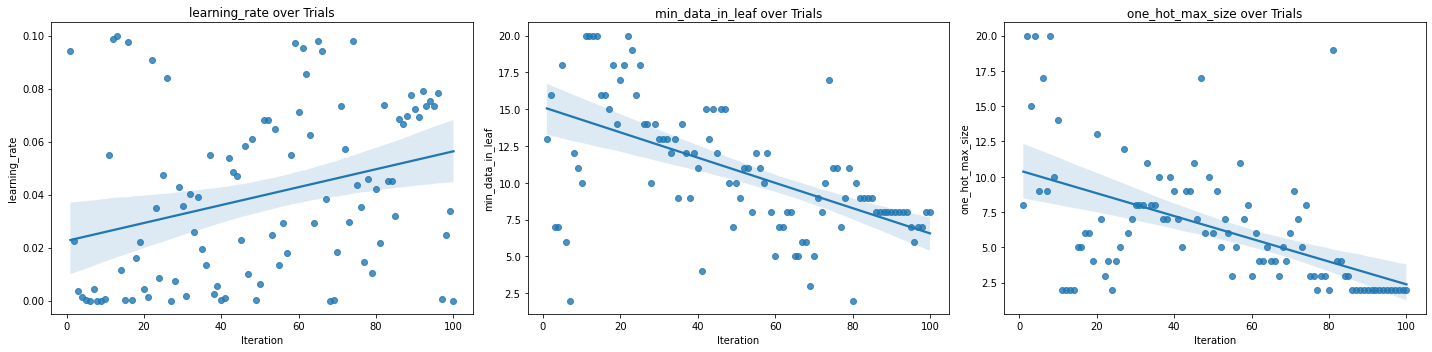

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

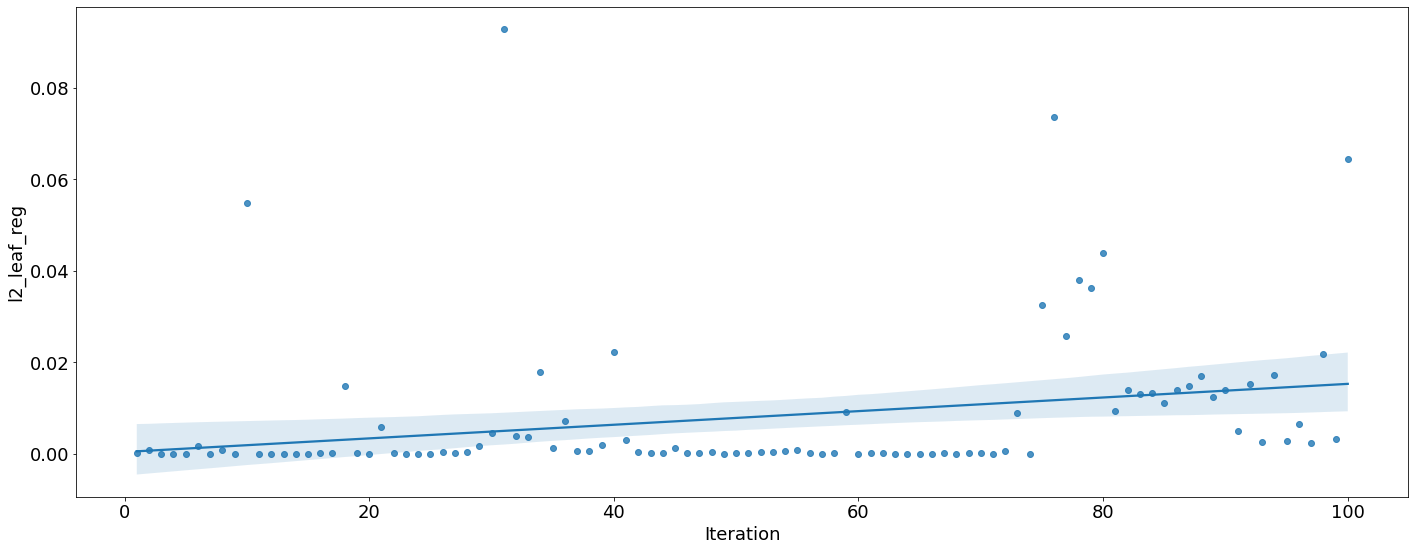

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=trials_df, 
                 label='Bayes Optimization') 
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 470,
 'l2_leaf_reg': 0.001169884935827506,
 'learning_rate': 0.099204154032085,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 10,
 'one_hot_max_size': 11,
 'random_state': 42,
 'scale_pos_weight': 0.9969416588857624}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/Model_PKL/

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(task_type='GPU', 
                                early_stopping_rounds=100,
                                rsm=1,
                                logging_level='Silent', 
                                **params)
# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    616594
         1.0       0.95      0.95      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[586786  29808]
 [ 31884 584710]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[144987   9162]
 [  9691 144458]]


Accuracy score: train: 0.950, test: 0.939
Precision score: train: 0.951, test: 0.940
Recall score: train: 0.948, 

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93885 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    91
logloss                                0.157276
datetime_start       2022-04-13 17:10:28.969106
datetime_complete    2022-04-13 17:14:42.014279
duration                 0 days 00:04:13.045173
depth                                        10
n_estimators                                470
l2_leaf_reg                             0.00117
learning_rate                          0.099204
min_data_in_leaf                             10
one_hot_max_size                             11
scale_pos_weight                       0.996942
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 50d - Reviews: 50 epochs

In [ ]:
# Define parameters for Word2Vec model
base_model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
base_model.build_vocab(features)
end = time.time()
print(round(end-start,2), 'seconds')
total_examples = base_model.corpus_count

Time to build vocab: 74.09 seconds


In [ ]:
# Set path
%cd /content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel/

/content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel


In [ ]:
# Load file with glove
glove_file = ('glove.6B.50d.txt')
tmp_file = get_tmpfile('test_word2vec.txt')

# Import vectors 
_ = glove2word2vec(glove_file, tmp_file) 
glove_vector = KeyedVectors.load_word2vec_format(tmp_file)
base_model.build_vocab([list(glove_vector.vocab.keys())], update=True)

In [ ]:
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
base_model.train(features, total_examples=total_examples, epochs=50) 
end = time.time()
print(round(end-start, 2), 'seconds')
base_model_wv = base_model.wv
glove = base_model
glove_wv = base_model.wv

Time to train model: 2943.23 seconds


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Save the model
wv = glove_wv
glove.wv.save_word2vec_format('glove.6B.50dModel_review125_50epochs.bin', 
                              binary=True)

In [ ]:
# Load model
word2vec_path = 'glove.6B.50dModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f8a3cbb2a10>)])

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_GPU_Optuna_100_glove.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0)
    }

    # Define model
    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU',
        allow_const_label=True, 
        random_state=seed_value,
        **params_catboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Catboost_GPU_Optuna_100_glove.pkl'):
    study = joblib.load('Catboost_GPU_Optuna_100_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
460:	learn: 0.1351336	test: 0.1589492	best: 0.1589047 (458)	total: 17.2s	remaining: 710ms
461:	learn: 0.1350874	test: 0.1589435	best: 0.1589047 (458)	total: 17.3s	remaining: 672ms
462:	learn: 0.1350178	test: 0.1589466	best: 0.1589047 (458)	total: 17.3s	remaining: 635ms
463:	learn: 0.1349522	test: 0.1589306	best: 0.1589047 (458)	total: 17.3s	remaining: 598ms
464:	learn: 0.1348888	test: 0.1589270	best: 0.1589047 (458)	total: 17.4s	remaining: 560ms
465:	learn: 0.1348340	test: 0.1589180	best: 0.1589047 (458)	total: 17.4s	remaining: 523ms
466:	learn: 0.1347568	test: 0.1589197	best: 0.1589047 (458)	total: 17.4s	remaining: 486ms
467:	learn: 0.1346873	test: 0.1589186	best: 0.1589047 (458)	total: 17.5s	remaining: 448ms
468:	learn: 0.1346417	test: 0.1589127	best: 0.1589047 (458)	total: 17.5s	remaining: 411ms
469:	learn: 0.1345737	test: 0.1589178	best: 0.1589047 (458)	total: 17.6s	remaining: 374ms
470:	learn: 0.1345321	test: 0.1589101	best: 0.158

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_depth': 'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg': 'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf': 'min_data_in_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_one_hot_max_size': 'one_hot_max_size'}, 
                 inplace=True)
trials_df.rename(columns={'params_scale_pos_weight': 'scale_pos_weight'}, 
                 inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_glove', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
91         91  0.158007 2022-04-15 05:19:10.730448 2022-04-15 05:22:26.560141   
93         93  0.158046 2022-04-15 05:25:42.218826 2022-04-15 05:28:57.956652   
92         92  0.158139 2022-04-15 05:22:26.560284 2022-04-15 05:25:42.218688   
75         75  0.158219 2022-04-15 04:28:21.505707 2022-04-15 04:31:35.188013   
96         96  0.158261 2022-04-15 05:35:28.585035 2022-04-15 05:38:44.435919   
..        ...       ...                        ...                        ...   
6           6  0.689561 2022-04-15 00:53:53.095570 2022-04-15 00:56:51.595760   
39         39  0.690283 2022-04-15 02:35:35.911632 2022-04-15 02:38:37.425401   
1           1  0.690397 2022-04-15 00:38:45.849765 2022-04-15 00:41:45.541255   
13         13  0.692369 2022-04-15 01:15:15.865272 2022-04-15 01:18:25.198819   
29         29  0.692847 2022-04-15 02:04:52.956743 2022-04-15 02:07:52.243778   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_GPU_Optuna_100_glove.html')
fig.show()

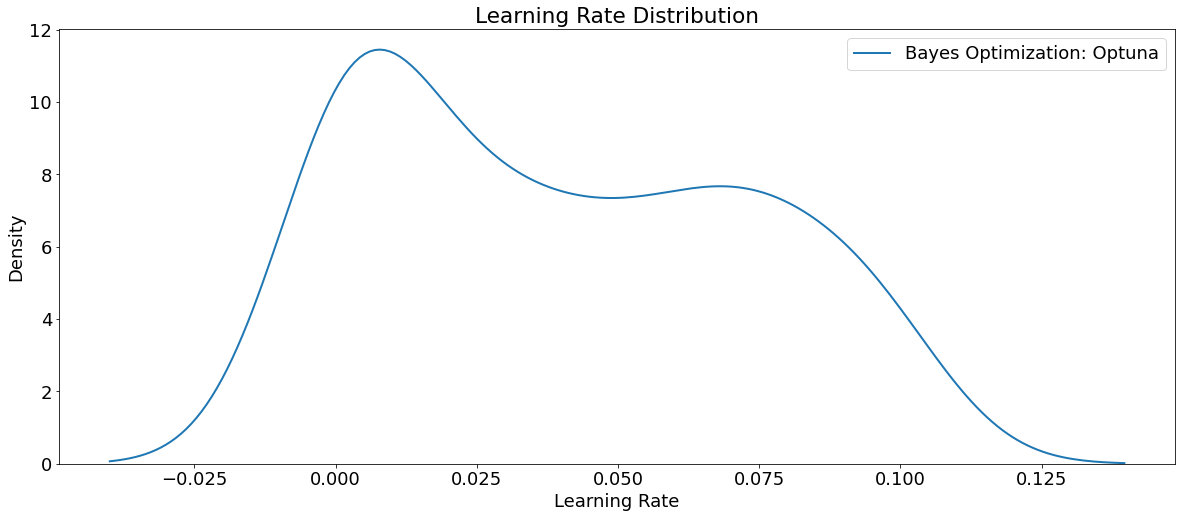

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

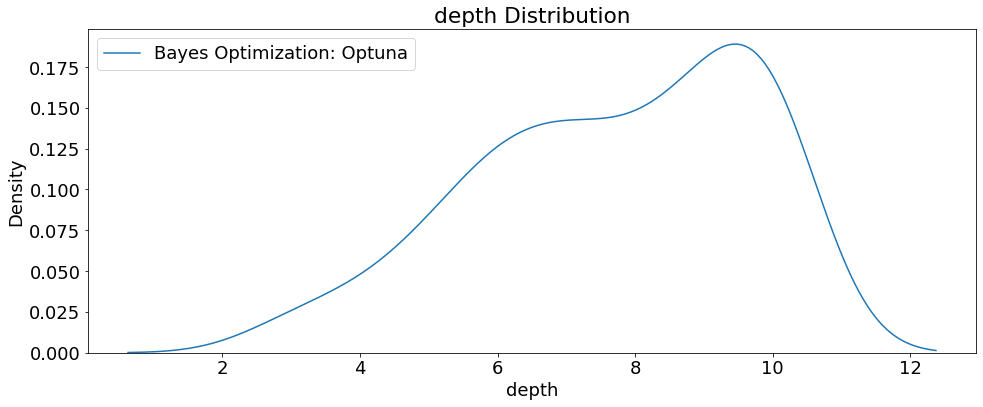

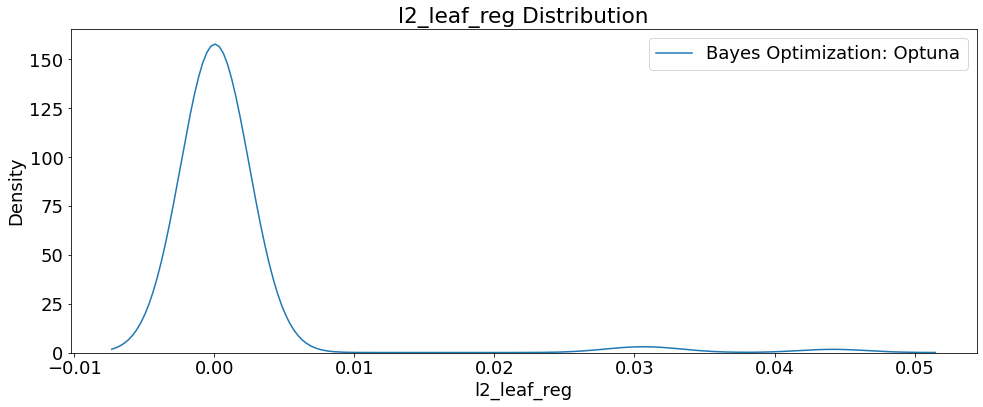

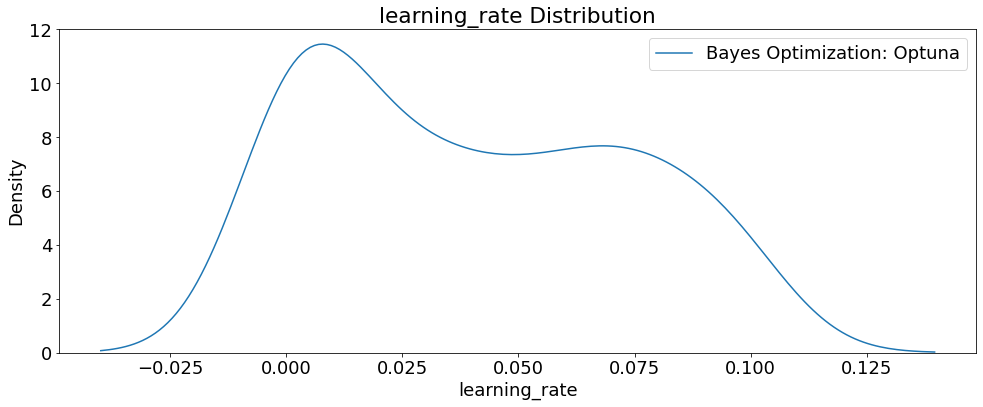

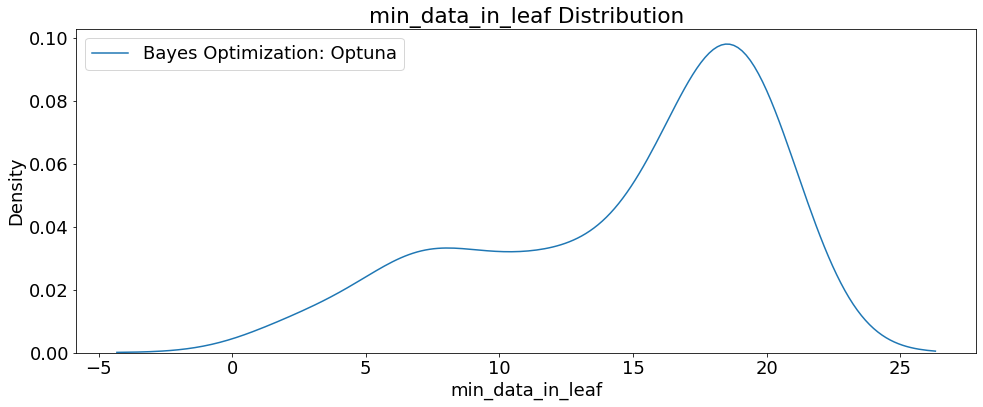

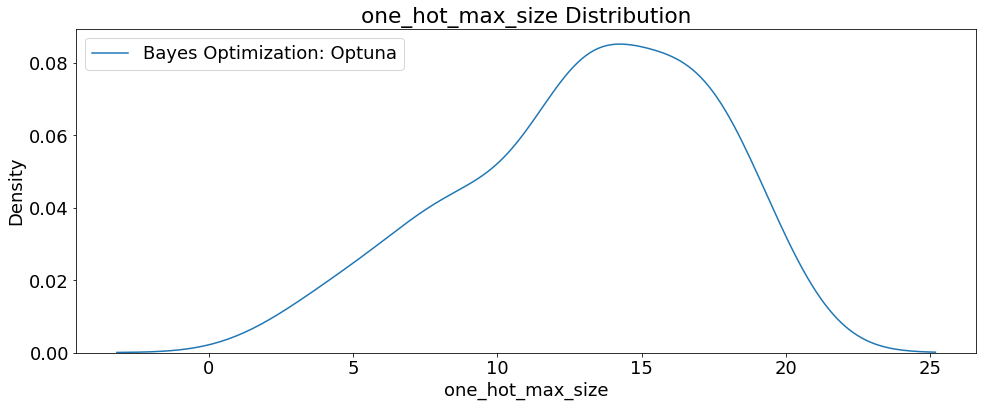

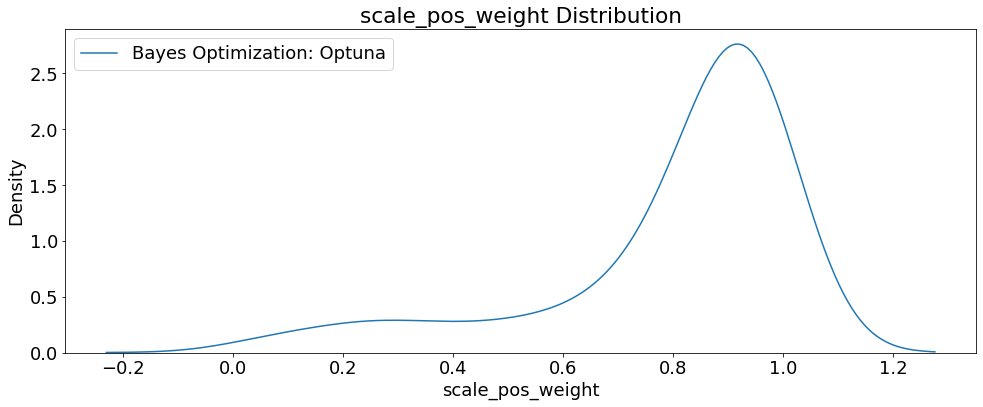

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

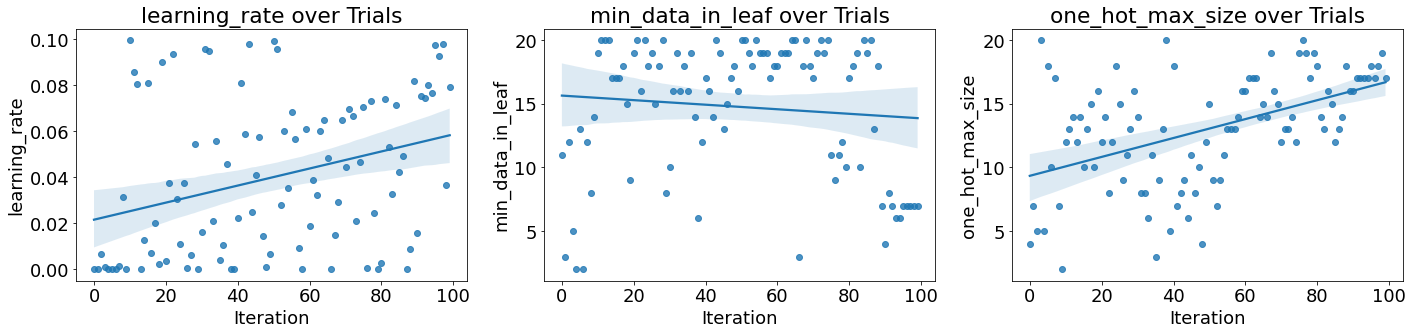

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

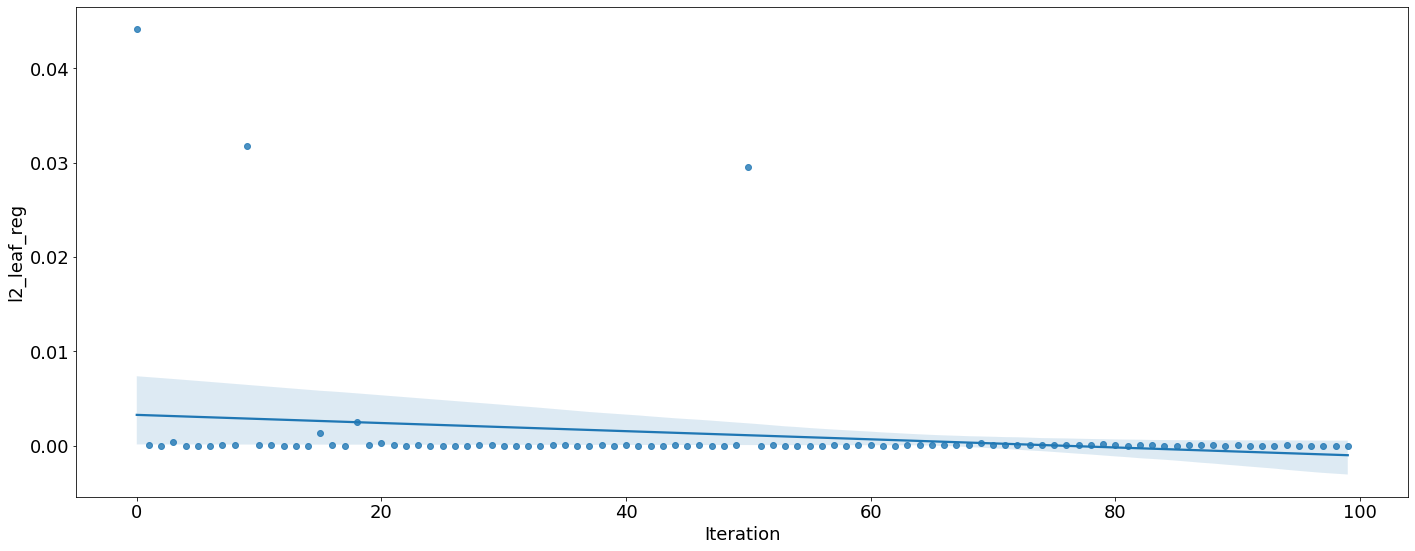

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=trials_df, 
                 label='Bayes Optimization') 
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 500,
 'l2_leaf_reg': 2.4907830177372423e-06,
 'learning_rate': 0.0752229446205332,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 8,
 'one_hot_max_size': 17,
 'random_state': 42,
 'scale_pos_weight': 0.9392585971530153}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(task_type='GPU', 
                                early_stopping_rounds=100,
                                rsm=1,
                                logging_level='Silent', 
                                **params)
# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_glove_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_glove_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    616594
         1.0       0.95      0.94      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[586627  29967]
 [ 34199 582395]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.93      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[145262   8887]
 [ 10080 144069]]


Accuracy score: train: 0.948, test: 0.938
Precision score: train: 0.951, test: 0.942
Recall score: train: 0

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93848 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    91
logloss                                0.158007
datetime_start       2022-04-15 05:19:10.730448
datetime_complete    2022-04-15 05:22:26.560141
duration                 0 days 00:03:15.829693
depth                                        10
n_estimators                                500
l2_leaf_reg                            0.000002
learning_rate                          0.075223
min_data_in_leaf                              8
one_hot_max_size                             17
scale_pos_weight                       0.939259
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 300d - Reviews: 50 epochs

In [ ]:
# Define parameters for Word2Vec model
base_model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
base_model.build_vocab(features)
end = time.time()
print(round(end-start,2), 'seconds')
total_examples = base_model.corpus_count

Time to build vocab: 76.49 seconds


In [ ]:
# Set path
%cd /content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel/

/content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel


In [ ]:
# Load file with glove
glove_file = ('glove.6B.300d.txt')
tmp_file = get_tmpfile('test_word2vec.txt')
_ = glove2word2vec(glove_file, tmp_file) 

# Import vectors 
glove_vector = KeyedVectors.load_word2vec_format(tmp_file)
base_model.build_vocab([list(glove_vector.vocab.keys())], update=True)

In [ ]:
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
base_model.train(features, total_examples=total_examples, epochs=50) 
end = time.time()
print(round(end-start,2), 'seconds')
base_model_wv = base_model.wv
glove = base_model
glove_wv = base_model.wv

Time to train model: 2968.42 seconds


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Save the model
wv = glove_wv
glove.wv.save_word2vec_format('glove.6B.300dModel_review125_50epochs.bin', 
                              binary=True)

In [ ]:
# Load model
word2vec_path = 'glove.6B.300dModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f2335d96350>)])

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_GPU_Optuna_100_glove300d.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0)
    }

    # Define model
    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU',
        allow_const_label=True, 
        random_state=seed_value,
        **params_catboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now(
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_glove300d.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_glove300d.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
86:	learn: 0.1790110	test: 0.1817685	best: 0.1817685 (86)	total: 3.48s	remaining: 10.9s
87:	learn: 0.1787401	test: 0.1815311	best: 0.1815311 (87)	total: 3.52s	remaining: 10.9s
88:	learn: 0.1784605	test: 0.1812787	best: 0.1812787 (88)	total: 3.55s	remaining: 10.8s
89:	learn: 0.1781999	test: 0.1810454	best: 0.1810454 (89)	total: 3.59s	remaining: 10.8s
90:	learn: 0.1779329	test: 0.1808175	best: 0.1808175 (90)	total: 3.63s	remaining: 10.7s
91:	learn: 0.1776895	test: 0.1806009	best: 0.1806009 (91)	total: 3.67s	remaining: 10.7s
92:	learn: 0.1774300	test: 0.1803815	best: 0.1803815 (92)	total: 3.71s	remaining: 10.6s
93:	learn: 0.1771530	test: 0.1801262	best: 0.1801262 (93)	total: 3.74s	remaining: 10.6s
94:	learn: 0.1769113	test: 0.1799168	best: 0.1799168 (94)	total: 3.78s	remaining: 10.5s
95:	learn: 0.1766172	test: 0.1796800	best: 0.1796800 (95)	total: 3.81s	remaining: 10.5s
96:	learn: 0.1763351	test: 0.1794213	best: 0.1794213 (96)	total: 3.85

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_depth': 'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg': 'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf': 'min_data_in_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_one_hot_max_size': 'one_hot_max_size'}, 
                 inplace=True)
trials_df.rename(columns={'params_scale_pos_weight': 'scale_pos_weight'}, 
                 inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_glove300d.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
68         68  0.157855 2022-04-16 01:08:42.596267 2022-04-16 01:11:51.529482   
55         55  0.158295 2022-04-16 00:27:43.805445 2022-04-16 00:30:49.795871   
97         97  0.158399 2022-04-16 02:40:06.082653 2022-04-16 02:43:15.393359   
90         90  0.158459 2022-04-16 02:17:41.624883 2022-04-16 02:20:54.565604   
91         91  0.158466 2022-04-16 02:20:54.565744 2022-04-16 02:24:07.427174   
..        ...       ...                        ...                        ...   
15         15  0.686486 2022-04-15 22:24:47.617154 2022-04-15 22:27:47.415213   
37         37  0.689928 2022-04-15 23:31:17.242163 2022-04-15 23:34:21.280808   
3           3  0.691478 2022-04-15 21:48:24.641413 2022-04-15 21:51:31.262517   
10         10  0.691590 2022-04-15 22:09:56.189563 2022-04-15 22:12:58.299812   
42         42  0.692487 2022-04-15 23:46:56.228423 2022-04-15 23:50:08.895532   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

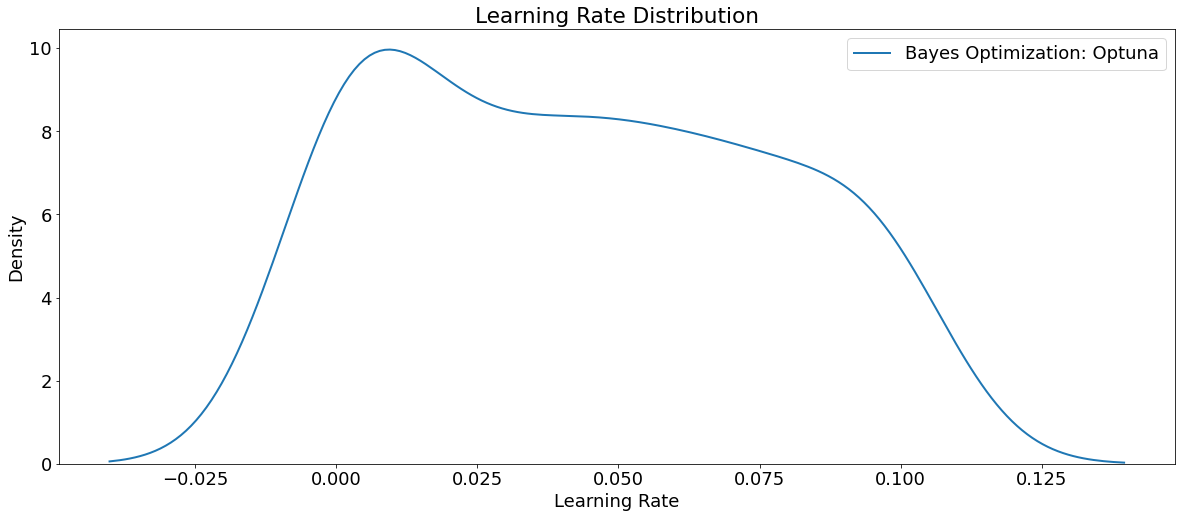

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

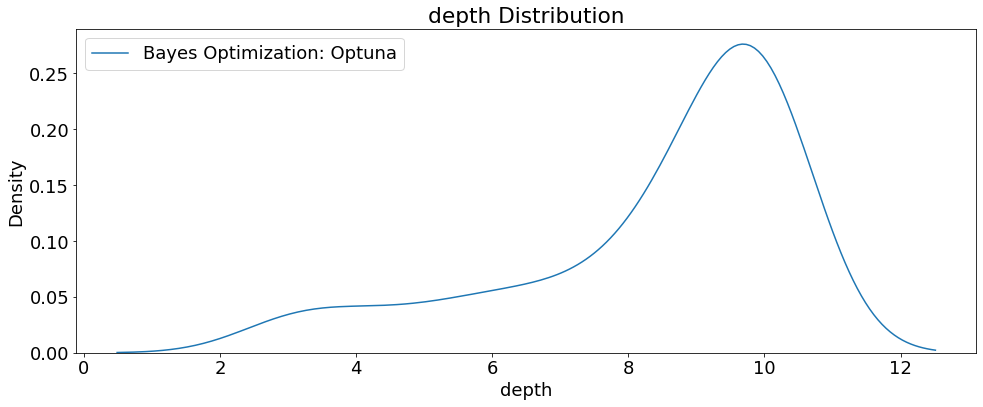

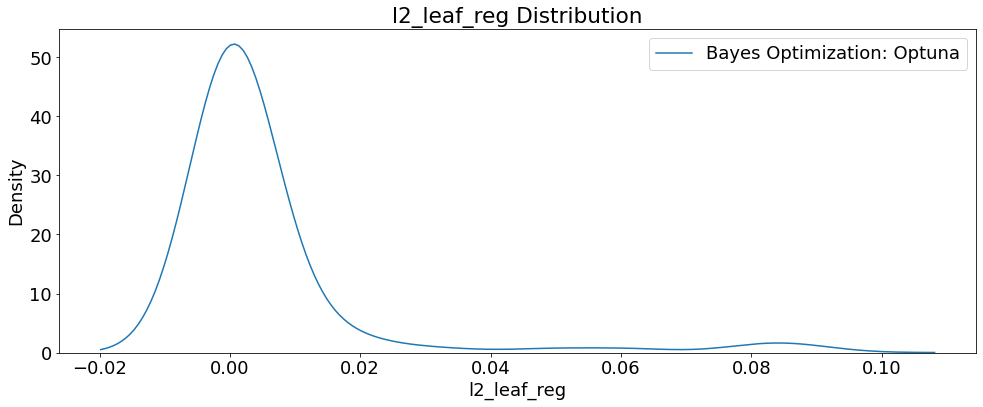

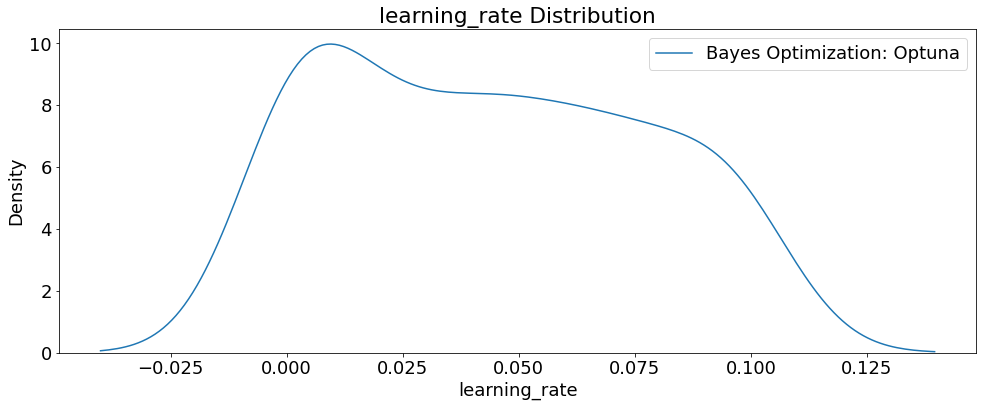

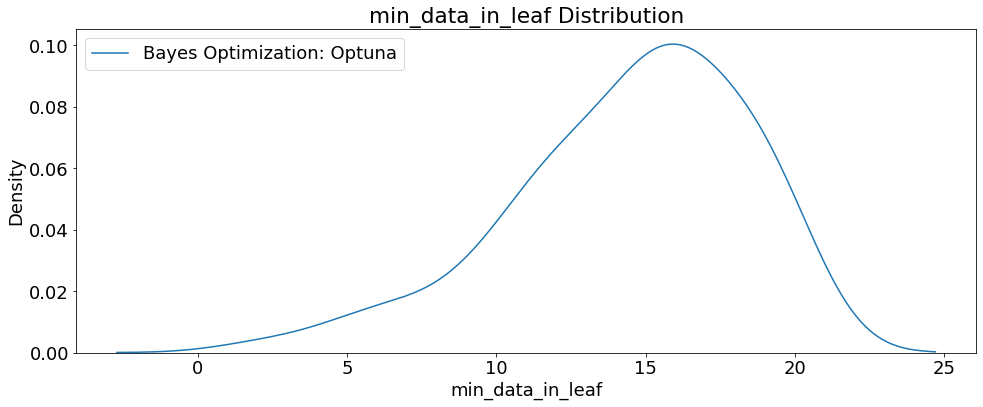

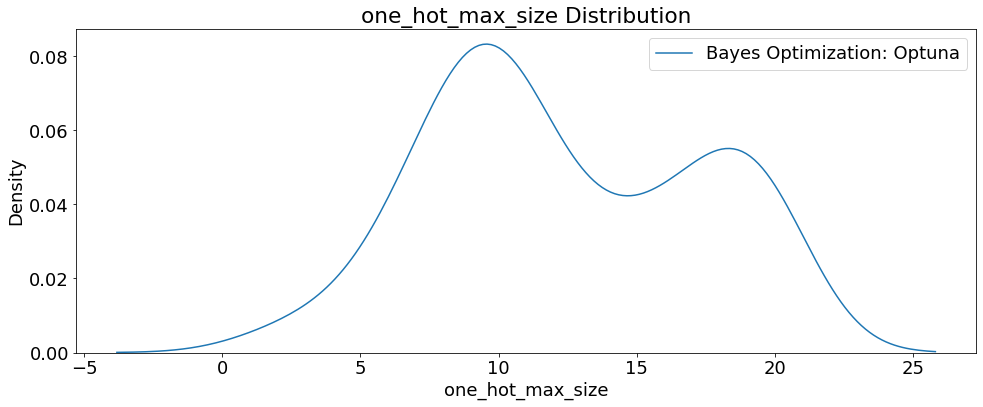

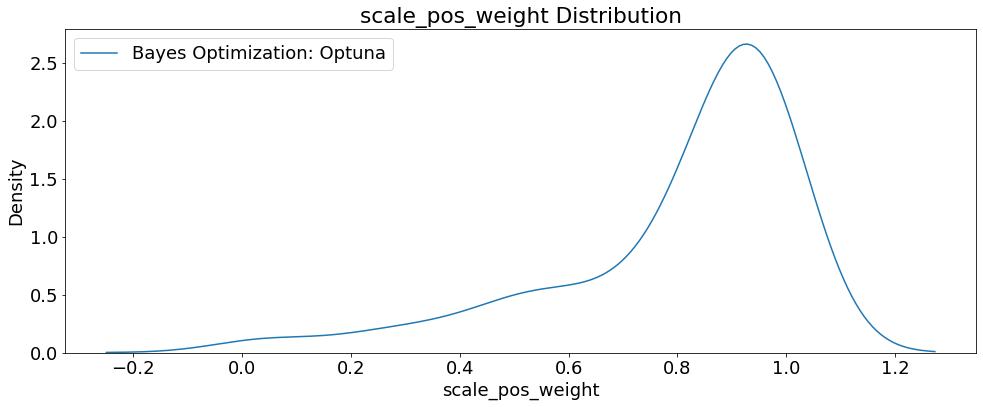

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

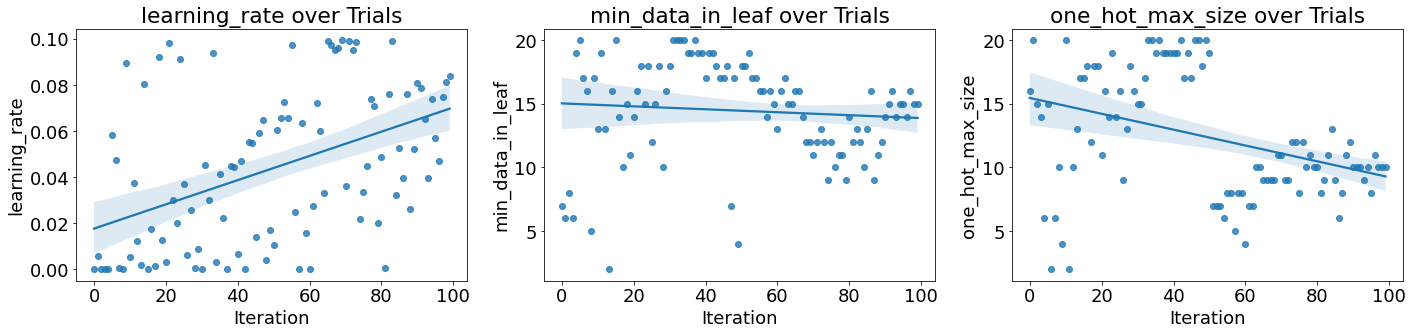

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

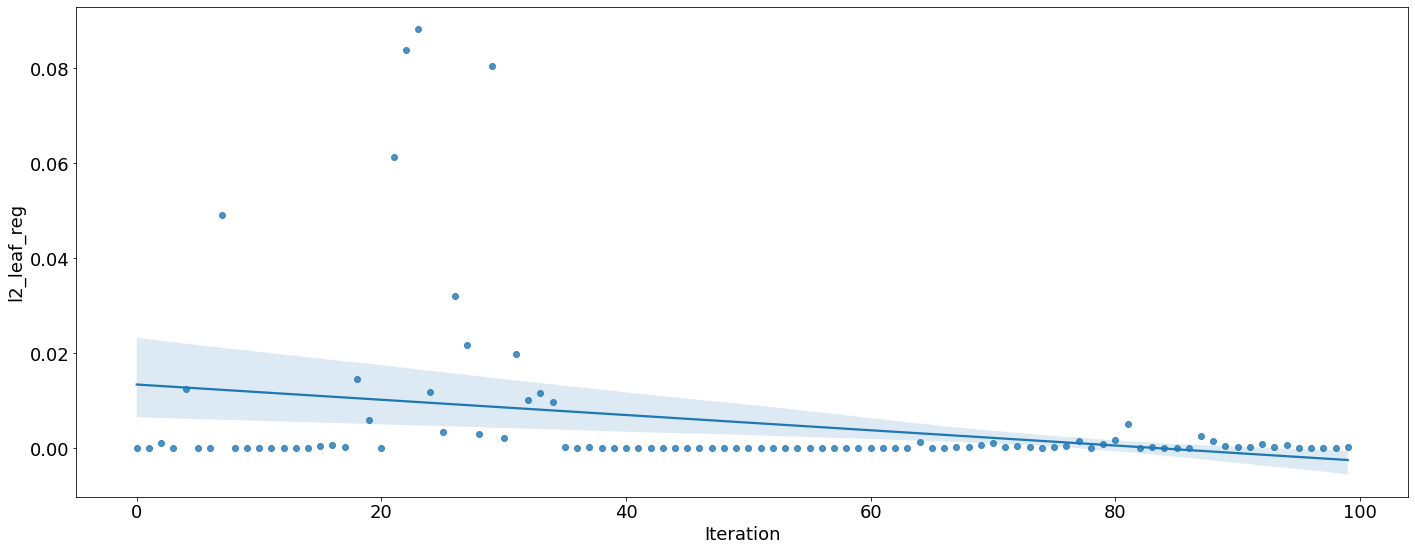

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=trials_df, 
                 label='Bayes Optimization') 
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_glove300d.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 420,
 'l2_leaf_reg': 0.00029402466989440095,
 'learning_rate': 0.09609042139346312,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 12,
 'one_hot_max_size': 9,
 'random_state': 42,
 'scale_pos_weight': 0.9877385995684106}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(task_type='GPU', 
                                early_stopping_rounds=100,
                                rsm=1,
                                logging_level='Silent', 
                                **params)
# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_glove300d.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_glove300d.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    616594
         1.0       0.95      0.95      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[585586  31008]
 [ 33068 583526]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[144903   9246]
 [  9704 144445]]


Accuracy score: train: 0.948, test: 0.939
Precision score: train: 0.950, test: 0.940
Recall score: train: 0

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93853 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    68
logloss                                0.157855
datetime_start       2022-04-16 01:08:42.596267
datetime_complete    2022-04-16 01:11:51.529482
duration                 0 days 00:03:08.933215
depth                                        10
n_estimators                                420
l2_leaf_reg                            0.000294
learning_rate                           0.09609
min_data_in_leaf                             12
one_hot_max_size                              9
scale_pos_weight                       0.987739
state                                  COMPLETE
Name: 0, dtype: object
